In [1]:
!pip install spacy
!python -m spacy download el_core_news_md
!pip install unidecode
!pip install optuna
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 MB 36.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_md')


**IMPORTS**

In [2]:
############################################ IMPORTS ################################################
import numpy as np # linear algebra
import pandas as pd # READ CSV
import spacy
import unicodedata as ud

# utilities
import re
# plotting

from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import os
from spacy.lang.el import stop_words
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import optuna
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import label_binarize
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support

**FUNCTIONS**

In [3]:
############################################ FUNCTION ################################################
def remove_hashtags(text):
    result = re.sub(r'#\S+', '', text)
    return ' '.join(result.split())

def remove_accents(text):
    tras = {ord('\N{COMBINING ACUTE ACCENT}'):None}
    ud.normalize('NFD', text).upper().translate(tras)
    result = ud.normalize('NFD', text).translate(tras)
    return ' '.join(result.split())

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return ' '.join(result.split())

def remove_more_characters(text):
    result = re.sub(r'(.)\1+', r'\1', text)
    return ' '.join(result.split())

def remove_at_words(text):
    result = re.sub(r'@\S+', '', text)
    return ' '.join(result.split())

def cleaning_punctuations(text):
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))
    result = text.translate(translator)
    return' '.join(result.split())

def remove_url(text):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', text)

def create_tokenizer(text):
    return word_tokenize(text)


def remove_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words_without_accents]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_stopwords_without_accents(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_english_stopwords(text):
    words = text.split()
    not_stopwords = [word for word in words if word.lower() not in stop_words]
    result = ' '.join(not_stopwords)
    return ' '.join(result.split())

def remove_one(text):
    words = text.split()
    filtered_words = [word for word in words if len(word) != 1]
    return ' '.join(filtered_words)
def remove_br(text):
    result = text.replace('<br />', '')
    result = result.replace('...', '')
    return ' '.join(result)


**INITIALIZATION**

In [4]:
nltk.download('punkt')
english_punctuations = string.punctuation + '«»'
punctuations_list = english_punctuations
nlp = spacy.load("el_core_news_md")
stop_words = nlp.Defaults.stop_words
nltk.download('stopwords')
english_stop_words = set(stopwords.words('english'))
stop_words_without_accents = create_tokenizer(remove_accents(' '.join(stop_words)))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**PREPROCESS FUNCTION**

In [5]:
#PREPROCESS
def create_model(file_path, file):
  dataset = pd.read_csv(file_path)

  dataset. shape
  dataset.dtypes
  np.sum(dataset.isnull().any(axis=1))
  dataset['New_ID'].unique()
  dataset['New_ID'].nunique()

  dataset['Text'] = dataset['Text'].str.lower()
  dataset['Text'] = dataset['Text'].apply(remove_hashtags)
  dataset['Text'] = dataset['Text'].apply(remove_url)
  dataset['Text'] = dataset['Text'].apply(remove_numbers)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_english_stopwords)
  dataset['Text'] = dataset['Text'].apply(remove_accents)
  dataset['Text'] = dataset['Text'].apply(remove_stopwords_without_accents)
  dataset['Text'] = dataset['Text'].apply(remove_at_words)
  dataset['Text'] = dataset['Text'].apply(cleaning_punctuations)
  dataset['Text'] = dataset['Text'].apply(create_tokenizer)
  pd.set_option('future.no_silent_downcasting', True)
  if 'train' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'train_set_result.csv'
  elif 'valid' in file:
    dataset['Sentiment'] = dataset['Sentiment'].replace({'POSITIVE': 2, 'NEGATIVE': 0, 'NEUTRAL': 1})
    path = 'valid_set_result.csv'
  else:
    path = 'test_set_result.csv'

  return dataset

**TRAIN AND VALID**

In [6]:
train_dataset = create_model('/kaggle/input/ys19-2023-assignment-3/train_set.csv', 'train')
valid_dataset = create_model('/kaggle/input/ys19-2023-assignment-3/valid_set.csv', 'valid')
train_dataset.head()
X_train = train_dataset['Text'].astype(str).tolist()
y_train = train_dataset['Sentiment']

X_validation = valid_dataset['Text'].astype(str).tolist()
y_validation = valid_dataset['Sentiment']

**EMBEDINGS**

In [7]:
# Εκπαιδεύουμε το μοντέλο Word2Vec με τα δεδομένα σου
word2vec_model = Word2Vec(sentences=train_dataset['Text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.save("greek_word2vec.model")

def get_embeddings(tokens, model):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    return sum(embeddings) / len(embeddings) if embeddings else None

train_dataset['word_embeddings'] = train_dataset['Text'].apply(lambda tokens: get_embeddings(tokens, word2vec_model))
valid_dataset['word_embeddings'] = valid_dataset['Text'].apply(lambda tokens: get_embeddings(tokens, word2vec_model))

In [8]:
train_dataset = train_dataset.dropna(subset=['word_embeddings'])
valid_dataset = valid_dataset.dropna(subset=['word_embeddings'])

train_labels = train_dataset['Sentiment']
valid_labels = valid_dataset['Sentiment']

# Tensor pyTorch
train_features = torch.stack([torch.tensor(embedding) for embedding in train_dataset['word_embeddings'].dropna().tolist()])
train_labels = torch.tensor(train_dataset['Sentiment'].dropna(), dtype=torch.long)
valid_features = torch.stack([torch.tensor(embedding) for embedding in valid_dataset['word_embeddings'].dropna().tolist()])
valid_labels = torch.tensor(valid_dataset['Sentiment'].dropna(), dtype=torch.long)

# Create the train, valid loader
train_dataset = TensorDataset(train_features, train_labels)
valid_dataset = TensorDataset(valid_features, valid_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

**RNN MODEL**

In [9]:
import torch
import torch.nn as nn

# RNN MODEL
# I CREATE THE CLASS HERE
class RNN(nn.Module):
    """
      Wrapper module for RNN, LSTM, GRU cells using pytorch api. The output is fed to a FFN for classification.
    """
    def __init__(self, cell_type, input_size, hidden_size, num_layers, output_size, dropout, skipconn=True, grad_clip=True):
        super(RNN, self).__init__()

        cells = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }
        self.cell_type = cell_type
        self.skipconn = skipconn
        self.grad_clip = grad_clip

        if skipconn == False:
            self.rnn = cells[cell_type](         
                input_size=input_size,           
                hidden_size=hidden_size,         
                num_layers=num_layers,
                batch_first=True,       
                bidirectional=True,
                dropout=dropout
            )
            if self.rnn.bidirectional == True:
                self.out = nn.Linear(hidden_size*2, output_size) 
            else:
                self.out = nn.Linear(hidden_size, output_size) 
        else:
            layers = []
            for i in range(num_layers):
                layers.append(cells[cell_type](
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=True,
                    dropout=dropout
                ))
            self.rnn = nn.Sequential(*layers)
            self.out = nn.Linear(hidden_size*2, output_size) 

            if self.skipconn:
                self.hidden_dim = self.rnn[0].hidden_size
                self.num_layers = self.rnn[0].num_layers

    def forward(self, x):
        if self.cell_type == 'LSTM':
            if self.skipconn:
                r_out, (h_n, h_c) = self.rnn[0](x)
            else:
                r_out, (h_n, h_c) = self.rnn(x)
        else:
            if self.skipconn:
                r_out, h_n = self.rnn[0](x)
            else:
                r_out, h_n = self.rnn(x)

        if self.skipconn:
            for i in range(0, self.num_layers-1):
                output1 = r_out
                out, h_n = self.rnn[i](r_out)
                output, h_n = self.rnn[i+1](out)
                r_out = output + output1

        out = self.out(r_out)
        return out

**OPTUNA FOR THE BEST HYPER PARAMETERS**

In [10]:
import optuna

input_size = 300
hidden_size = 64
num_layers = 4
output_size = 10
dropout = 0.8
cell_type = 'LSTM'
num_epochs = 3
LR = 0.01
#WITH OPTUNA
# I USE OPTUNA FIND THE BEST PARAMS
def objective(trial):
    # Sample hyperparameters
    input_size = 300
    hidden_size = trial.suggest_int('hidden_size', 32, 128)
    num_layers = trial.suggest_int('num_layers', 1, 4)
    output_size = 3 
    dropout = trial.suggest_uniform('dropout', 0.0, 0.8)
    # Assuming LSTM cell
    cell_type = 'LSTM'

    # Define the RNN model
    net = RNN(cell_type, input_size, hidden_size, num_layers, output_size, dropout)

    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()

    # Start train mode here
    net.train()

    # Accumulate loses
    losses = []
    
    #the count
    step_count = 0

    # for epoch
    for epoch in range(num_epochs):
        loss_sum = 0
        for step, (x, y) in enumerate(train_loader):

            # clear gradients for this training step
            optimizer.zero_grad()

            b_x = x.view(x.size(0), -1)

            # batch y
            b_y = y
            b_y = b_y.type(torch.LongTensor)

            output = net(b_x)

            loss = loss_func(output, b_y)
            losses.append(loss.item())
            loss_sum += loss.item()
            
            # For visualization
            if net.grad_clip:
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0, norm_type=2)
            step_count += 1

            # backpropagation - compute gradients
            loss.backward()

            # apply gradients
            optimizer.step()

    # Compute validation accuracy
    with torch.no_grad():
        net.eval()
        test_output = net(valid_features)
        pred_y = torch.argmax(test_output, dim=1).squeeze()
        accuracy_val = accuracy_score(valid_labels, pred_y)

    return accuracy_val

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters and their values
best_params = study.best_params
print("Best hyperparameters is:", best_params)


[I 2024-02-13 20:35:29,494] A new study created in memory with name: no-name-815581b8-6b76-448c-96fd-c3969c3654c2
/tmp/ipykernel_18/65074924.py:19: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout = trial.suggest_uniform('dropout', 0.0, 0.8)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4896994853038165 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-02-13 20:35:43,852] Trial 0 finished with value: 0.3605283605283605 and parameters: {'hidden_size': 41, 'num_layers': 3, 'dropout': 0.4896994853038165}. Best is trial 0 with value: 0.3605283605283605.
/tmp/ipykernel_18/65074924.py:19: FutureWarning: suggest_uniform has been deprecate

Best hyperparameters is: {'hidden_size': 78, 'num_layers': 4, 'dropout': 0.225862260664492}


**DEFINE AND CREATE THE RNN MODEL**

In [11]:
# Best hyperparameters: {'hidden_size': 101, 'num_layers': 2, 'dropout': 0.16703239798054653}
#I USE THE BEST PARAMS WHERE I HAVE FIND for n_trials = 50
input_size = 300
hidden_size = 101
num_layers = 2
output_size = 10
dropout = 0.16703239798054653
cell_type = 'LSTM'
net = RNN(cell_type, input_size, hidden_size, num_layers, output_size, dropout)
print(net)
num_epochs = 3
LR = 0.01

optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all net parameters
loss_func = nn.CrossEntropyLoss()

# Remove the channel dimension
for step, (x_val, y_val) in enumerate(valid_loader):
    x_val = x_val.view(x_val.size(0), -1)
    pass
print(x_val.shape, y_val.shape)

RNN(
  (rnn): Sequential(
    (0): LSTM(300, 101, batch_first=True, dropout=0.16703239798054653, bidirectional=True)
    (1): LSTM(300, 101, batch_first=True, dropout=0.16703239798054653, bidirectional=True)
  )
  (out): Linear(in_features=202, out_features=10, bias=True)
)
torch.Size([28, 100]) torch.Size([28])


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.16703239798054653 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [12]:
print(best_params)

{'hidden_size': 78, 'num_layers': 4, 'dropout': 0.225862260664492}


**TRAINING MY MODEL**

In [13]:
# Best hyperparameters: {'hidden_size': 108, 'num_layers': 3, 'dropout': 0.45740778143615446}

# Start train mode
net.train()

# Accumulate losses
losses = []
train_losses = []
valid_losses = []
# Count the number of batches given to the model
step_count = 0

# Evaluate the progress every # batches
print_every = 50

pred = []
train_acc = []
val_acc = []
i = 0

# Iterate over the whole dataset for one epoch
for epoch in range(num_epochs):
    loss_sum = 0
    # Generate batch data
    for step, (x, y) in enumerate(train_loader):

        # clear gradients for this training step
        optimizer.zero_grad()
        b_x = x.view(x.size(0), -1)
        b_y = y
        b_y = b_y.type(torch.LongTensor)
        output = net(b_x)

        loss = loss_func(output, b_y)
        losses.append(loss.item())
        loss_sum += loss.item()
        
        if net.grad_clip:
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=3.0, norm_type=2)
        step_count += 1

        loss.backward()

        # apply gradients
        optimizer.step()

        # evaluate every N batches
        if step % print_every == 0:
            i += 1
            with torch.no_grad():
                output = net(b_x)
                pred_y = torch.argmax(output, dim=1).squeeze()
                accuracy_train = accuracy_score(b_y, pred_y)
                train_acc.append(accuracy_train)
                
                # Faster inference
                net.eval()

                test_output = net(x_val)

                # Get predicted class
                pred_y = torch.argmax(test_output, dim=1).squeeze()

                pred = pred_y
                # Calculate accuracy
                accuracy_val = accuracy_score(y_val, pred_y)
                val_acc.append(accuracy_val)
                print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy_val)

            # Return to training mode
            net.train()
            
    loss_sum = loss_sum / step
    train_losses.append(loss_sum)

    loss_sum = 0
    with torch.no_grad():
        for step, (x, y) in enumerate(valid_loader):
            b_x = x.view(x.size(0), -1)

            # batch y
            b_y = y
            b_y = b_y.type(torch.LongTensor)

            output = net(b_x)

            loss_sum += loss_func(output, b_y)

    loss_sum = loss_sum / step
    valid_losses.append(loss_sum)

Epoch:  0 | train loss: 2.2636 | test accuracy: 0.32
Epoch:  0 | train loss: 1.1884 | test accuracy: 0.29
Epoch:  0 | train loss: 1.0905 | test accuracy: 0.36
Epoch:  0 | train loss: 1.0985 | test accuracy: 0.39
Epoch:  0 | train loss: 1.0970 | test accuracy: 0.46
Epoch:  0 | train loss: 1.0788 | test accuracy: 0.32
Epoch:  0 | train loss: 1.1073 | test accuracy: 0.32
Epoch:  0 | train loss: 1.0773 | test accuracy: 0.36
Epoch:  0 | train loss: 1.0859 | test accuracy: 0.39
Epoch:  0 | train loss: 1.1032 | test accuracy: 0.46
Epoch:  0 | train loss: 1.0904 | test accuracy: 0.39
Epoch:  0 | train loss: 1.1045 | test accuracy: 0.54
Epoch:  0 | train loss: 1.0858 | test accuracy: 0.32
Epoch:  0 | train loss: 1.1005 | test accuracy: 0.32
Epoch:  0 | train loss: 1.1132 | test accuracy: 0.39
Epoch:  0 | train loss: 1.1139 | test accuracy: 0.29
Epoch:  0 | train loss: 1.0787 | test accuracy: 0.46
Epoch:  0 | train loss: 1.1054 | test accuracy: 0.39
Epoch:  0 | train loss: 1.1931 | test accuracy

**PRINT SCORE**

In [14]:
with torch.no_grad():
    net.eval()
    test_output = net(valid_features)
    y_validation_pred = torch.argmax(test_output, dim=1).squeeze()

print("Accuracy valid: ", accuracy_score(valid_labels, y_validation_pred))
print("Validation class:\n", classification_report(valid_labels, y_validation_pred))

Accuracy valid:  0.35955710955710957
Validation class:
               precision    recall  f1-score   support

           0       0.39      0.15      0.22      1724
           1       0.34      0.66      0.45      1704
           2       0.39      0.27      0.32      1720

    accuracy                           0.36      5148
   macro avg       0.37      0.36      0.33      5148
weighted avg       0.37      0.36      0.33      5148



**USE test.csv and create submission.csv**

In [15]:
from sklearn.preprocessing import LabelEncoder

# Set the model to evaluation mode
net.eval()

#for the test
test_dataset = create_model('/kaggle/input/ys19-2023-assignment-3/test_set.csv', 'test')
X_test = test_dataset['Text'].astype(str).tolist()
test_dataset['word_embeddings'] = test_dataset['Text'].apply(lambda x: get_embeddings(x, word2vec_model))

# Convert text embeddings to PyTorch tensors
test_dataset['word_embeddings'] = test_dataset['word_embeddings'].ffill()
test_dataset = test_dataset.dropna(subset=['word_embeddings'])
test_features = torch.stack([torch.tensor(embedding) for embedding in test_dataset['word_embeddings'].dropna().tolist()])

# Make predictions using the trained model where I have create
with torch.no_grad():
    test_outputs = net(test_features)
    _, test_predicted = torch.max(test_outputs, 1)

# Define and fit a LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(['POSITIVE','NEGATIVE', 'NEUTRAL'])
test_predictions = label_encoder.inverse_transform(test_predicted.numpy())

test_dataset['party'] = test_predictions

# Assuming you have a 'New_ID' column in your test dataset
result_df = pd.DataFrame({'Id': test_dataset.New_ID, 'Predicted': test_predictions})

# Save the result to a new CSV file
result_df.to_csv('submission.csv', index=False)

**LEARNING CURVE**

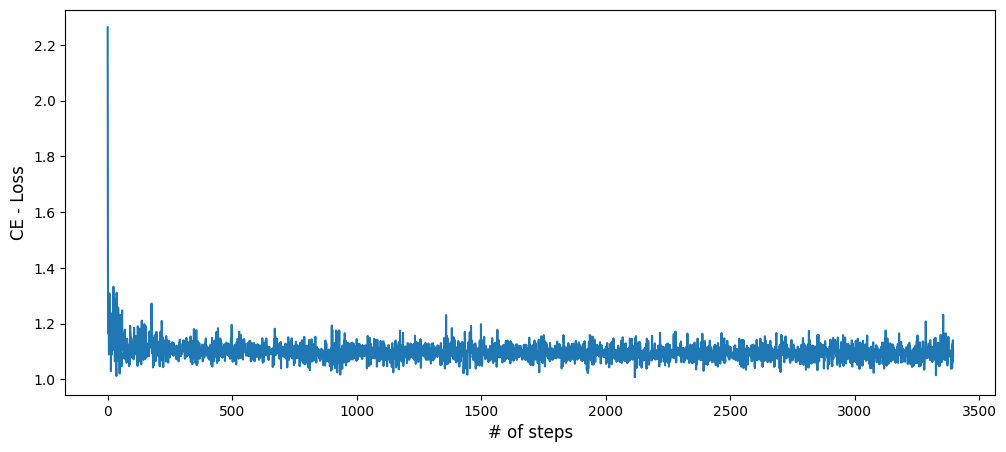

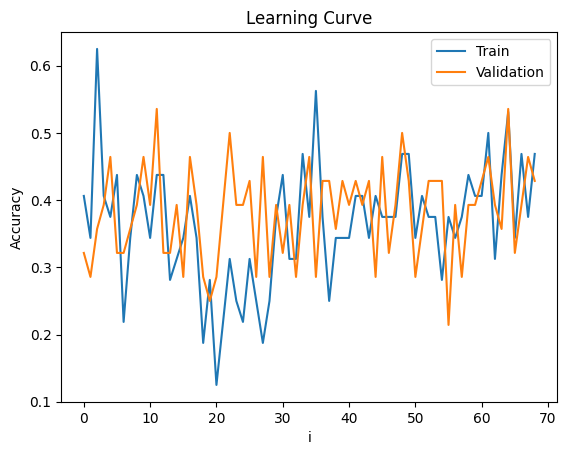

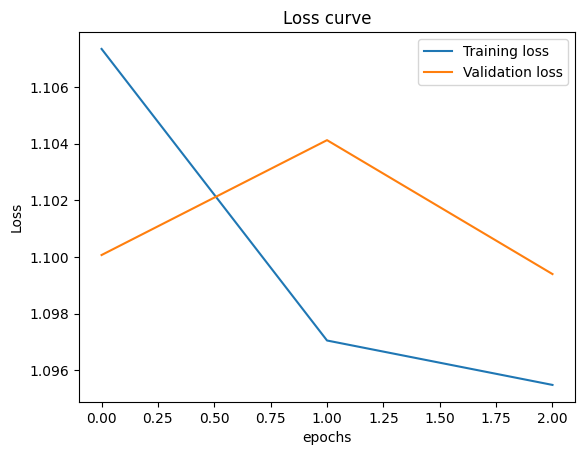

In [16]:
# Plot results
plt.figure(figsize=(12,5))
plt.plot(losses)
plt.xlabel('# of steps', fontsize=12)
plt.ylabel('CE - Loss', fontsize=12)
plt.show()

plt.title("Learning Curve")
plt.plot([j for j in range(i)], train_acc, label="Train")
plt.plot([j for j in range(i)], val_acc, label="Validation")
plt.xlabel("i")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.plot([i for i in range(num_epochs)], train_losses, label = "Training loss")
plt.plot([i for i in range(num_epochs)], valid_losses, label = "Validation loss")
plt.legend()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.show()

**ROC CURVE**

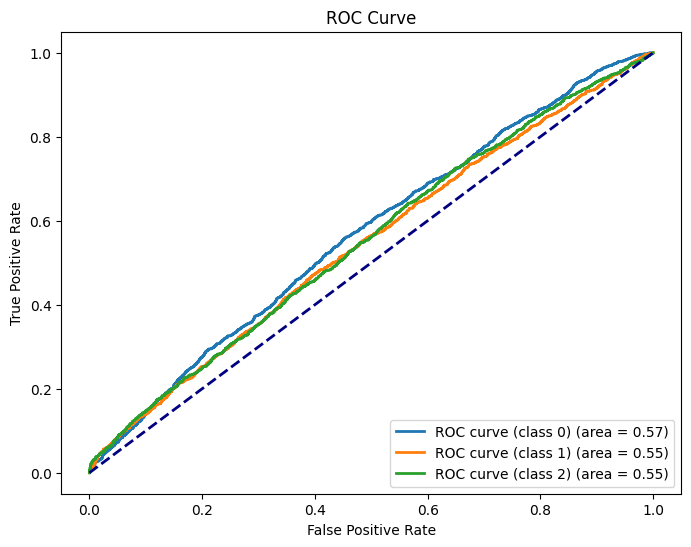

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

net.eval()
all_probs = []
all_labels = []

# Iterate over the validation dataset
for x_val, y_val in valid_loader:
    with torch.no_grad():
        output = net(x_val)
        probs = torch.softmax(output, dim=1).numpy()
    
    all_probs.append(probs)
    all_labels.append(y_val.numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

# Binarize the true labels
y_val_binarized = label_binarize(all_labels, classes=np.unique(all_labels))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(all_labels))):  
    fpr[i], tpr[i], _ = roc_curve(y_val_binarized[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(all_labels))):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (area = {:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


**Confusion matrix**

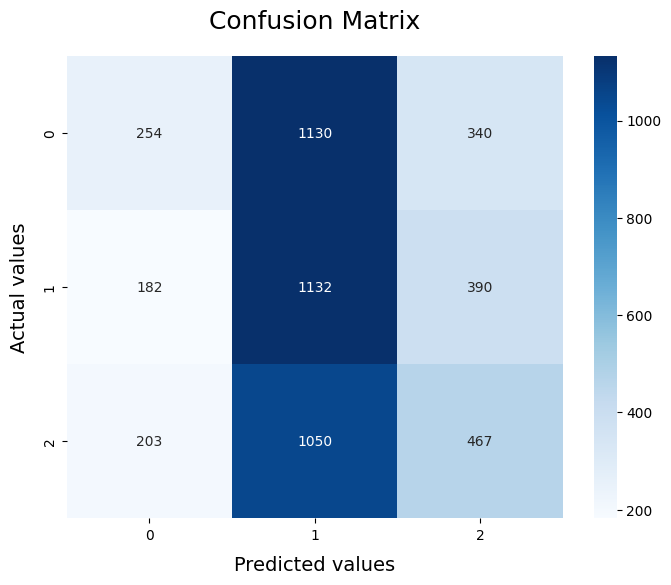

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def confusion_matrix_rnn(model, data_loader):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in data_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

    cf_matrix = confusion_matrix(y_true, y_pred)

    # Plotting
    plt.figure(figsize=(8, 6))
    sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

# Usage
confusion_matrix_rnn(net, valid_loader)
